In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [2]:
class Config:
    TRAIN_PATH = '../inputs/train.csv'
    TEST_PATH = '../inputs/test.csv'
    TRAIN_LABELS = '../inputs/train_labels.csv'
    SAMPLE_SUBMISSION = '../inputs/sample_submission.csv'

In [3]:
train_df = pd.read_csv(Config.TRAIN_PATH, usecols=lambda x: x not in ['fullscreen','hq','music'])
train_labels = pd.read_csv(Config.TRAIN_LABELS)

In [4]:
train_df.rename(columns={'session_id':'session'},inplace=True)

In [5]:
train_labels['question'] = train_labels['session_id'].str.split('q').str[-1].astype('int')
train_labels['session'] = train_labels['session_id'].str.split('_').str[0].astype('int64')

In [6]:
def q2l(x):
    if x <= 3:
        return '0-4'
    if x <= 12:
        return '5-12'
    return '13-22'
train_labels['level_group'] = train_labels['question'].apply(lambda x: q2l(x))

In [14]:
train_df.room_fqid.unique()

array(['tunic.historicalsociety.closet',
       'tunic.historicalsociety.basement',
       'tunic.historicalsociety.entry',
       'tunic.historicalsociety.collection',
       'tunic.historicalsociety.stacks', 'tunic.kohlcenter.halloffame',
       'tunic.capitol_0.hall', 'tunic.historicalsociety.closet_dirty',
       'tunic.historicalsociety.frontdesk',
       'tunic.humanecology.frontdesk', 'tunic.drycleaner.frontdesk',
       'tunic.library.frontdesk', 'tunic.library.microfiche',
       'tunic.capitol_1.hall', 'tunic.historicalsociety.cage',
       'tunic.historicalsociety.collection_flag', 'tunic.wildlife.center',
       'tunic.flaghouse.entry', 'tunic.capitol_2.hall'], dtype=object)

In [97]:
np.isnan([np.nan]).sum()

1

In [115]:
event_features =  ['checkpoint_click','cutscene_click', 'person_click', 'navigate_click',
                   'observation_click', 'notification_click', 'object_click',
                   'object_hover', 'map_hover', 'map_click', 'notebook_click']
name_features = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
room_features = ['historicalsociety',
          'kohlcenter',
          'capitol_0',
          'humanecology',
          'drycleaner',
          'library',
          'capitol_1',
          'wildlife',
          'flaghouse','capitol_2']
num_features = [ 
        'page', 
        'room_coor_x', 
        'room_coor_y', 
        'screen_coor_x', 
        'screen_coor_y', 
        'hover_duration']
def groupby_apply(g):
    res = {}
    res['text_fqid'] = pd.isnull(g['text_fqid']).sum()

    event_name_dict = Counter(g['event_name'].values)
    event_sequence = g['event_name'].values[1:]
    room_event_dict = Counter(g['room_event'].values)
    room_sequence = g['main_room'].values[1:]
    for col in event_features:
        res[f'{col}_sum'] = event_name_dict.get(col, 0)
        for col2 in room_features:
            res[f'{col}_{col2}_sum'] = room_event_dict.get(f'{col}_{col2}',0)
    room_dict = Counter(g['room_fqid'].values)
    for col in room_features:
        res[f'{col}_sum'] = room_dict.get(col, 0)
    for col in num_features:
        res[f'{col}_mean'] = np.mean(g[col])
        res[f'{col}_max'] = np.max(g[col])
        res[f'{col}_min'] = np.min(g[col])
        res[f'{col}_std'] = np.std(g[col])

    elapsed_time_diff = np.diff(g['elapsed_time'])
    res['elapsed_time_diff_mean'] = np.mean(elapsed_time_diff)
    res['elapsed_time_diff_std'] = np.std(elapsed_time_diff)
    res['elapsed_time_diff_max'] = np.max(elapsed_time_diff)
    res['elapsed_time_diff_min'] = np.min(elapsed_time_diff)
    res['duration'] = g['elapsed_time'].values[-1] - g['elapsed_time'].values[0]
    res['elapsed_time_diff_positive'] = len(elapsed_time_diff[elapsed_time_diff>0])
    for col in event_features:
        elapsed_time_diff_event = elapsed_time_diff[event_sequence==col]
        if len(elapsed_time_diff_event) > 0 :
            res[f'elapsed_time_diff_{col}_mean'] = np.mean(elapsed_time_diff_event)
            res[f'elapsed_time_diff_{col}_max'] = np.max(elapsed_time_diff_event)
            res[f'elapsed_time_diff_{col}_min'] = np.min(elapsed_time_diff_event)
        else:
            res[f'elapsed_time_diff_{col}_mean'] = 0
            res[f'elapsed_time_diff_{col}_max'] = 0
            res[f'elapsed_time_diff_{col}_min'] = 0
    for col in room_features:
        elapsed_time_diff_room = elapsed_time_diff[room_sequence==col]
        if len(elapsed_time_diff_room) > 0 :
            res[f'elapsed_time_diff_{col}_mean'] = np.mean(elapsed_time_diff_room)
            res[f'elapsed_time_diff_{col}_max'] = np.max(elapsed_time_diff_room)
            res[f'elapsed_time_diff_{col}_min'] = np.min(elapsed_time_diff_room)
        else:
            res[f'elapsed_time_diff_{col}_mean'] = 0
            res[f'elapsed_time_diff_{col}_max'] = 0
            res[f'elapsed_time_diff_{col}_min'] = 0
    res['object_per_sum_navigate_object'] = res['object_click_sum'] / (res['object_click_sum']+res['navigate_click_sum']+1)
    res['person_per_sum_navigate_object'] = res['person_click_sum'] / (res['person_click_sum']+res['navigate_click_sum']+1)
    res['object_per_sum_person_object'] = res['object_click_sum'] / (res['object_click_sum']+res['person_click_sum']+1)
    return pd.Series(res)

In [116]:
def feature_engineering(df, meta):
    df['main_room'] = df['room_fqid'].str.split('.').str[1]
    df['room_event'] =  df['event_name']+'_' + df['main_room']
    X = df.groupby(['session','level_group']).apply(groupby_apply).reset_index()
    X = meta.merge(X,how='left', on=['session','level_group'])
    X['question'] = X['question'].astype('category')
    X['level_group'] = X['level_group'].astype('category')
    for i in range(1,19):
        X[f'q{i}'] = X['question'] == i
    for i in ['0-4','5-12','13-22']:
        X[i] =  X['level_group'] == i
    return X

In [117]:
%%time
X = feature_engineering(train_df, train_labels)

CPU times: total: 1min 37s
Wall time: 1min 42s


In [118]:
FEATURES = X.columns[5:]
len(FEATURES)

249

In [120]:
n_splits=5
gkf = GroupKFold(n_splits=n_splits)
oof = np.zeros(X.shape[0])
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, valid_index) in enumerate(gkf.split(X, groups=X['session'])):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)

    xgb_params = {
        'objective' : 'binary:logistic',
        'eval_metric':'logloss',
        'learning_rate': 0.01,
        'max_depth': 5,
        'n_estimators': 3000,
        'early_stopping_rounds': 50,
        'tree_method':'gpu_hist',
        'subsample':0.8,
        'colsample_bytree': 0.8,
        'tree_method': 'gpu_hist',
        'seed':42,
        'use_label_encoder' : False}

    X_train = X.iloc[train_index][FEATURES]
    X_valid = X.iloc[valid_index][FEATURES]
    y_train = X.iloc[train_index]['correct'].values
    y_valid = X.iloc[valid_index]['correct'].values
        # TRAIN MODEL
    clf =  XGBClassifier(**xgb_params)
    clf.fit(X_train.astype('float32'), y_train,
            eval_set=[(X_train.astype('float32'), y_train), (X_valid.astype('float32'),y_valid)],
            verbose=100)
    print(f'({clf.best_ntree_limit}), ',end='')

        # SAVE MODEL, PREDICT VALID OOF
    models[i] = clf
    oof[valid_index] = clf.predict_proba(X_valid)[:,1]

    print()

#########################
### Fold 1
#########################
[0]	validation_0-logloss:0.69033	validation_1-logloss:0.69032
[100]	validation_0-logloss:0.55638	validation_1-logloss:0.55591
[200]	validation_0-logloss:0.52209	validation_1-logloss:0.52156
[300]	validation_0-logloss:0.50878	validation_1-logloss:0.50879
[400]	validation_0-logloss:0.50117	validation_1-logloss:0.50228
[500]	validation_0-logloss:0.49578	validation_1-logloss:0.49819
[600]	validation_0-logloss:0.49165	validation_1-logloss:0.49547
[700]	validation_0-logloss:0.48822	validation_1-logloss:0.49374
[800]	validation_0-logloss:0.48522	validation_1-logloss:0.49238
[900]	validation_0-logloss:0.48262	validation_1-logloss:0.49148
[1000]	validation_0-logloss:0.48021	validation_1-logloss:0.49077
[1100]	validation_0-logloss:0.47797	validation_1-logloss:0.49021
[1200]	validation_0-logloss:0.47583	validation_1-logloss:0.48969
[1300]	validation_0-logloss:0.47388	validation_1-logloss:0.48925
[1400]	validation_0-logloss:0.47214	val

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df.tail(50)
    #Define size of bar plot
    plt.figure(figsize=(20,10))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

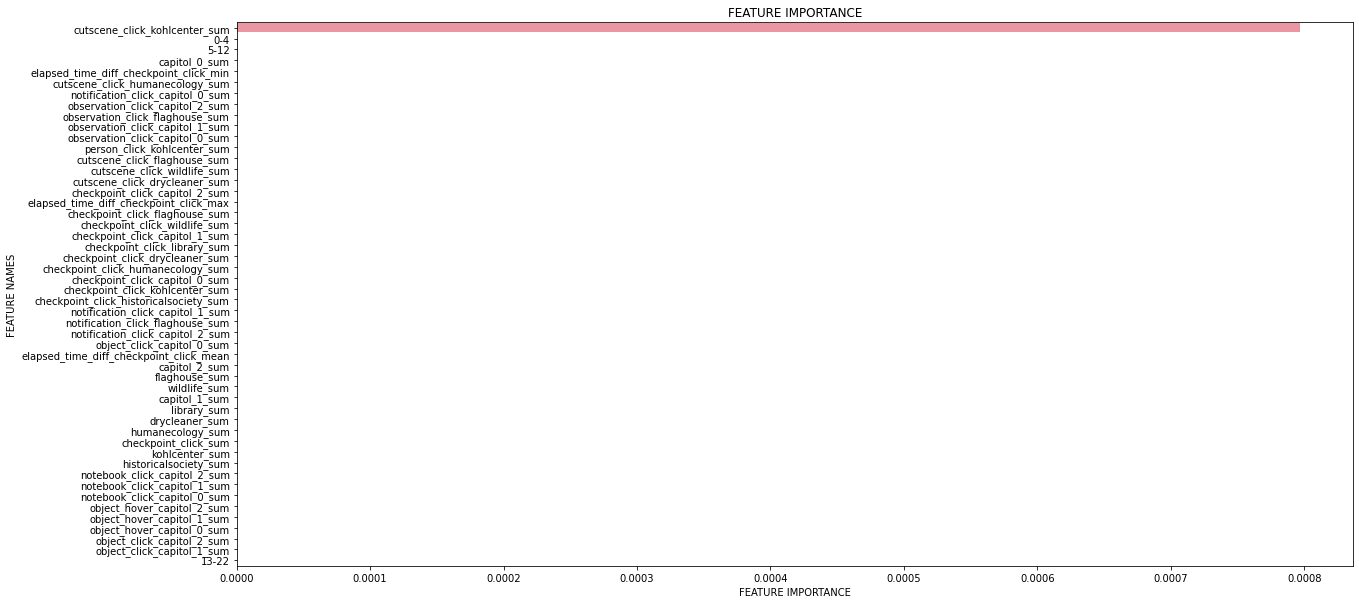

In [126]:
feat_imp = {}
for k, v in models.items():
    for x, y in zip(v.feature_importances_, v.feature_names_in_):
        if y not in feat_imp:
            feat_imp[y] = x
        else:
            feat_imp[y]+=x
plot_feature_importance(list(feat_imp.values()),list(feat_imp.keys()),'')

In [131]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.38,0.92,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof>threshold).astype('int')
    m = f1_score(X['correct'], preds, average='macro')
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.90, 0.91, 

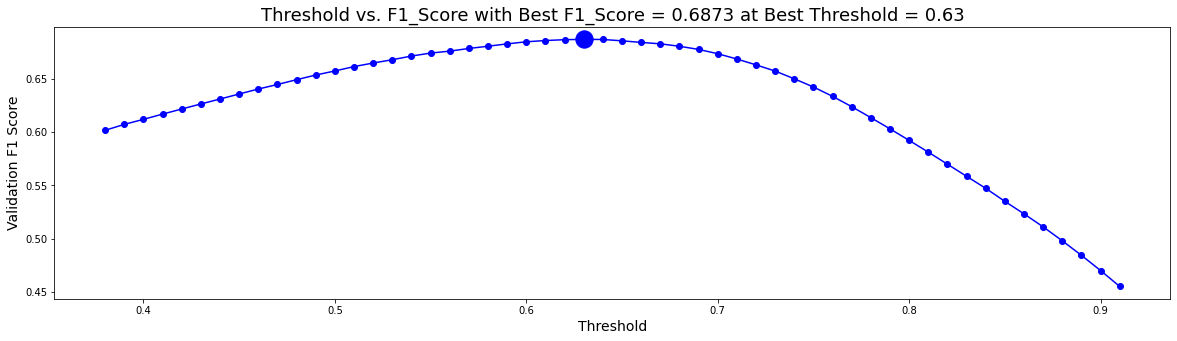

In [132]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.4f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [135]:
xgb_params = {
        'objective' : 'binary:logistic',
        'eval_metric':'logloss',
        'learning_rate': 0.01,
        'max_depth': 5,
        'n_estimators': 3000,
        'subsample':0.8,
        'colsample_bytree': 0.8,
        'tree_method': 'gpu_hist',
        'seed':42,
        'use_label_encoder' : False}

In [136]:
clf =  XGBClassifier(**xgb_params)

In [137]:
clf.fit(X[FEATURES],X['correct'])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=3000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [140]:
clf.save_model('student-performance.json')

In [142]:
FEATURES.values

array(['text_fqid', 'checkpoint_click_sum',
       'checkpoint_click_historicalsociety_sum',
       'checkpoint_click_kohlcenter_sum',
       'checkpoint_click_capitol_0_sum',
       'checkpoint_click_humanecology_sum',
       'checkpoint_click_drycleaner_sum', 'checkpoint_click_library_sum',
       'checkpoint_click_capitol_1_sum', 'checkpoint_click_wildlife_sum',
       'checkpoint_click_flaghouse_sum', 'checkpoint_click_capitol_2_sum',
       'cutscene_click_sum', 'cutscene_click_historicalsociety_sum',
       'cutscene_click_kohlcenter_sum', 'cutscene_click_capitol_0_sum',
       'cutscene_click_humanecology_sum', 'cutscene_click_drycleaner_sum',
       'cutscene_click_library_sum', 'cutscene_click_capitol_1_sum',
       'cutscene_click_wildlife_sum', 'cutscene_click_flaghouse_sum',
       'cutscene_click_capitol_2_sum', 'person_click_sum',
       'person_click_historicalsociety_sum',
       'person_click_kohlcenter_sum', 'person_click_capitol_0_sum',
       'person_click_humanecol